In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import cycler as cycler
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
confirmurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirm = pd.read_csv(confirmurl)
deathurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(deathurl)
recoverurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(recoverurl)

In [ ]:
confirm

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595,56676,56717,56779,56873,56943,57019,57144,57160,57242,57364,57492,57534,57612,57721,57793,57898,58037,58214,58312,58542,58730,58843,59015,59225,59370,59576,59745,59939,60122,60300
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183,126531,126795,126936,127192,127509,127795,128155,128393,128518,128752,128959,129128,129307,129456,129594,129694,129842,129980,130114,130270,130409,130537,130606,130736,130859,130977,131085,131185,131238,131276
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524,117622,117739,117879,118004,118116,118251,118378,118516,118645,118799,118975,119142,119323,119486,119642,119805,119992,120174,120363,120562,120736,120922,121112,121344,121580,121866,122108,122311,122522,122717
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174,12231,12286,12328,12363,12409,12456,12497,12545,12581,12614,12641,12641,12712,12771,12805,12805,12874,12917,12942,13007,13024,13060,13083,13121,13148,13198,13232,13232,13282,13295
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579,22631,22717,22885,23010,23108,23242,23331,23457,23549,23697,23841,23951,24122,24300,24389,24518,24661,24883,25051,25279,25492,25609,25710,25942,26168,26431,26652,26815,26993,27133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,2579,2586,2586,2591,2594,2594,2603,2617,2620,2626,2631,2637,2648,2659,2668,2683,2692,2693,2705,2714,2733,2758,2772,2781,2785,2791,2800,2812,2824,2830,2833,2843,2852,2857,2865,2910,2928,2942,2962,2985
271,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,232038,233549,234748,236462,238248,240065,242353,244645,246893,248482,251288,253922,256461,259133,262017,264395,265897,268132,270856,272767,274690,276407,278135,279753,280741,282270,284280,286028,287680,289120,290259,290972,292052,293466,294550,295601,296462,296462,297638,298203
272,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3816,3900,3969,4033,4115,4247,4357,4531,4620,4697,4798,4881,4975,5047,5133,5233,5276,5357,5446,5507,5582,5657,5715,5770,5812,5858,5918,5960,6020,6056,6105,6137,6183,6220,6263,6294,6317,6325,6341,6363
273,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,87318,87583,87583,87872,88012,88199,88418,88549,88

In [ ]:
thaiconfirm = confirm[confirm["Country/Region"]=="Thailand"]
thaideath = death[death["Country/Region"]=="Thailand"]
thairecover = recover[recover["Country/Region"]=="Thailand"]
thaiconfirm.rename(index={244: 'confirm'},inplace=True)
thaiconfirm.drop(thaiconfirm.columns[0:4], axis=1, inplace=True)
thaideath.rename(index={244: 'death'},inplace=True)
thaideath.drop(thaideath.columns[0:4], axis=1, inplace=True)
thairecover.rename(index={229: 'recover'},inplace=True)
thairecover.drop(thairecover.columns[0:4], axis=1, inplace=True)
tmp = pd.concat([thaiconfirm,thaideath,thairecover])
tmp.rename(columns=pd.to_datetime, inplace=True)
thaicovid = tmp.transpose()
thaicovid['daily cases'] = thaicovid['confirm'].diff().fillna(thaicovid.confirm)
thaicovid['daily deaths'] = thaicovid['death'].diff().fillna(thaicovid.death)
thaicovid['daily recover'] = thaicovid['recover'].diff().fillna(thaicovid.recover)
#thaicovid

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


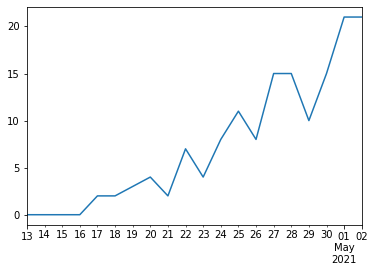

In [ ]:
thaicovid["daily deaths"].iloc[-20:].plot()

In [ ]:
def country_covid_by_id(id_of_country):
  # This outputs the "thaicovid"-like object
  Countryconfirm = confirm[confirm.index==id_of_country];
  Countrydeath = death[death.index==id_of_country];
  Countryconfirm.rename(index={id_of_country: 'confirm'},inplace=True)
  Countryconfirm.drop(Countryconfirm.columns[0:4], axis=1, inplace=True)
  Countrydeath.rename(index={id_of_country: 'death'},inplace=True)
  Countrydeath.drop(Countrydeath.columns[0:4], axis=1, inplace=True)
  tmp = pd.concat([Countryconfirm,Countrydeath])
  tmp.rename(columns=pd.to_datetime, inplace=True)
  countryinfo = tmp.transpose()
  countryinfo['daily cases'] = countryinfo['confirm'].diff().fillna(countryinfo.confirm)
  countryinfo['daily deaths'] = countryinfo['death'].diff().fillna(countryinfo.death)
  return countryinfo


def backestimate(covid,deathpercase=0.003,delay=9):
  new_df = pd.DataFrame(index=covid[:-delay].index)
  backest = []
  newcase = []
  for index, row in covid[delay:].iterrows():
    backest.append(row['daily deaths']/deathpercase)
  new_df['Back estimate'] = pd.Series(np.array(backest),index=new_df.index)
  new_df['New cases'] = pd.Series(covid[:-delay]["daily cases"])
  return new_df

def bandbackestimate(covid,deathpercase=0.003,delayupper=14,delaylower=7,onsetexpo = 15):
  df_low = backestimate(covid,deathpercase,delaylower)
  df_up = backestimate(covid,deathpercase,delayupper)
  new_df = pd.DataFrame(index=df_low.index)
  new_df["New cases"] = pd.Series(df_low["New cases"])
  new_df["Lower delay"] = pd.Series(df_low["Back estimate"])
  backest_up = []
  for index, row in covid[delayupper:].iterrows():
    backest_up.append(row['daily deaths']/deathpercase)
  xup = range(len(backest_up[-onsetexpo:]))
  def func(x,a,b):
    return a*np.exp(b*x)
  params = curve_fit(func, xup, backest_up[-onsetexpo:])
  xup_tmp = xup[-1]
  #extra = []
  while len(backest_up) < len(df_low.index):
    yup = func(xup_tmp,*params[0])
    backest_up.append(func(xup_tmp,*params[0]))
    #extra.append(func(xup_tmp,*params[0]))
    xup_tmp += 1
  new_df["Upper delay"] = pd.Series(np.array(backest_up),index=new_df.index)
  """
  new_df["Upper delay"] = pd.Series(df_up["Back estimate"])
  x = new_df.index.astype(float).values
  y = new_df["Upper delay"].values
  params = curve_fit(lambda x, a, b: a*np.exp(b*x),x,y)
  xnan = new_df[pd.isnull(new_df["Upper delay"])].index.astype(float).values
  new_df["Upper delay"][xnan] = lambda x, params: xnan
  """
  #df_extra = pd.DataFrame(index=df_low.index[-len(extra):])
  #df_extra["Extrapolation"] = pd.Series(extra,index=df_low.index[-len(extra):])
  return new_df

#def bandplot()

def drawbandplot(backestCountry,country_name,death_per_case):
  # Added by Pawin
  ax = backestCountry["New cases"].plot(title=country_name+": case-fatality = "+ "{:.1%}".format(death_per_case))
  backestCountry["Upper delay"].plot(style='r--',alpha=0.1)
  backestCountry["Lower delay"].plot(style='r-',alpha=0.3)
  #extradf["Extrapolation"].plot(style='g-',alpha=1)
  ax.fill_between(backestCountry.index,backestCountry["Upper delay"],backestCountry["Lower delay"],color='red',alpha=0.1)
  plt.legend()
  plt.savefig(country_name+"_band.png",dpi=300)

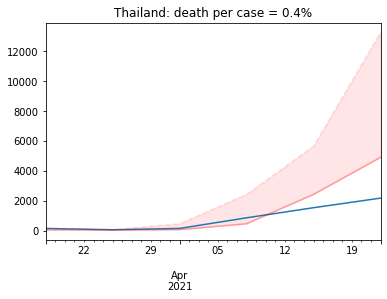

In [ ]:
date = 40
up = 14
low = 7
onset = 15
backestthailand = bandbackestimate(thaicovid,deathpercase=0.004,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
#backestthailand = backestthailand.iloc[-date:].resample("7D").mean()
#extradf = extradf.resample("7D").mean()
ax = backestthailand["New cases"].plot(title="Thailand: death per case = 0.4%")
backestthailand["Upper delay"].plot(style='r--',alpha=0.1)
backestthailand["Lower delay"].plot(style='r-',alpha=0.3)
#extradf["Extrapolation"].plot(style='g-',alpha=1)
ax.fill_between(backestthailand.index,backestthailand["Upper delay"],backestthailand["Lower delay"],color='red',alpha=0.1)
plt.savefig("Thailand_band.png",dpi=300)

            New cases    low delay     up delay
2021-03-30       48.0   333.333333     0.000000
2021-03-31       42.0     0.000000     0.000000
2021-04-01       26.0     0.000000     0.000000
2021-04-02       58.0     0.000000     0.000000
2021-04-03       84.0     0.000000   666.666667
2021-04-04       96.0     0.000000   666.666667
2021-04-05      194.0   333.333333  1000.000000
2021-04-06      250.0   333.333333  1333.333333
2021-04-07      334.0     0.000000   666.666667
2021-04-08      405.0     0.000000  2333.333333
2021-04-09      559.0     0.000000  1333.333333
2021-04-10      789.0     0.000000  2666.666667
2021-04-11      967.0     0.000000  3666.666667
2021-04-12      985.0     0.000000  2666.666667
2021-04-13      965.0   666.666667  5000.000000
2021-04-14     1335.0   666.666667  5000.000000
2021-04-15     1543.0  1000.000000  3333.333333
2021-04-16     1585.0  1333.333333  5000.000000
2021-04-17     1547.0   666.666667  7000.000000
2021-04-18     1767.0  2333.333333  7000

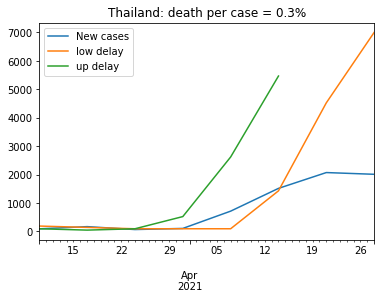

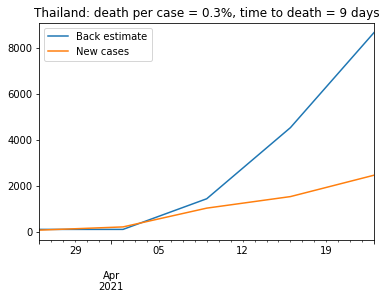

In [ ]:
#backestimate(thaicovid).iloc[-30:].plot(title="Thailand: Death per case = 0.3%, delay = 9 days")
backestimate(thaicovid).iloc[-30:].resample("7D").mean().plot(title="Thailand: death per case = 0.3%, time to death = 9 days")
plt.savefig("Thailand.png",dpi=300)

    Province/State Country/Region        Lat  ...  5/1/21  5/2/21  5/3/21
244            NaN       Thailand  15.870032  ...   67044   68984   71025

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


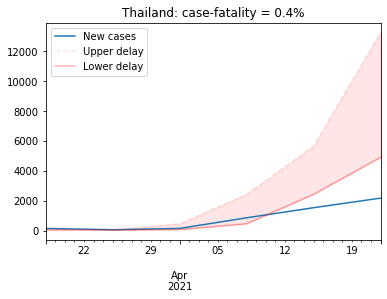

In [ ]:
country_name = "Thailand"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=244
deathpc=0.004
date = 40
up = 14
low = 7
onset = 15
#thaicovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

In [ ]:
death[264:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
264,Turks and Caicos Islands,United Kingdom,21.694000,-71.797900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
265,NaN,United Kingdom,55.378100,-3.436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,126382,126445,126515,126573,126592,126615,126670,126713,126764,126816,126826,126836,126862,126882,126927,126980,127040,127080,127087,127100,127123,127161,127191,127225,127260,127270,127274,127307,127327,127345,127385,127417,127428,127434,127451,127480,127502,127517,127524,127538
266,NaN,Uruguay,-32.522800,-55.765800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,843,856,875,901,915,928,953,974,1009,1041,1071,1101,1146,1191,1231,1275,1363,1414,1462,1533,1595,1647,1726,1788,1848,1908,1971,2022,2083,2160,2227,2283,2326,2391,2452,2497,2563,2616,2669,2724
267,NaN,Uzbekistan,41.377491,64.585262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,623,624,624,625,626,626,628,629,630,630,630,631,631,632,633,634,634,634,634,634,634,634,634,635,636,638,638,639,640,640,641,642,643,645,646,646,647,649,650,652
268,NaN,Vanuatu,-15.376700,166.959200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
269,NaN,Venezuela,6.423800,-66.589700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1521,1532,1543,1555,1565,1577,1589,1602,1615,1629,1647,1662,1678,1693,1705,1720,1739,1759,1778,1795,1815,1834,1853,1870,1888,1905,1925,1944,1965,1987,2009,2028,2047,2065,2082,2099,2117,2136,2155,2172
270,NaN,Vietnam,14.058324,108.277199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
271,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2501,2521,2537,2557,2581,2599,2614,2627,2645,2661,2681,2706,2716,2735,2753,2781,2812,2838,2860,2883,2901,2923,2937,2955,2983,3017,3047,3078,3096,3115,3138,3151,3167,3184,3201,3206,3231,3249,3249,3272
272,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,800,810,820,832,851,863,882,888,906,916,932,946,955,976,986,1004,1022,1031,1049,1068,1073,1083,1097,1108,1119,1126,1132,1138,1147,1157,1165,1175,1187,1205,1207,1216,1222,1226,1229,1233
273,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1187,1191,1194,1198,1200,1200,1202,1208,1212,1215,1215,1220,1222,1224,1224,1225,1226,1226,1226,1227,1229,1229,1230,1233,1234,1235,1236,1236,1238,1240,1245,1245,1246,1248,1249,1249,1250,1251,1251,1253


In [ ]:
### UK test
UKconfirm = confirm[confirm.index==265]
UKdeath = death[death.index==265]
UKconfirm.rename(index={265: 'confirm'},inplace=True)
UKconfirm.drop(UKconfirm.columns[0:4], axis=1, inplace=True)
#print(UKconfirm)
UKdeath.rename(index={265: 'death'},inplace=True)
UKdeath.drop(UKdeath.columns[0:4], axis=1, inplace=True)
tmp = pd.concat([UKconfirm,UKdeath])
tmp.rename(columns=pd.to_datetime, inplace=True)
UKcovid = tmp.transpose()
UKcovid['daily cases'] = UKcovid['confirm'].diff().fillna(UKcovid.confirm)
UKcovid['daily deaths'] = UKcovid['death'].diff().fillna(UKcovid.death)
#UKcovid

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


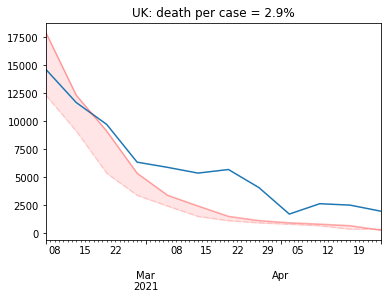

In [ ]:
date = 80
up = 14
low = 7
onset = 15
backestUK = bandbackestimate(UKcovid,deathpercase=0.029,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
ax = backestUK["New cases"].plot(title="UK: death per case = 2.9%")
backestUK["Upper delay"].plot(style='r--',alpha=0.1)
backestUK["Lower delay"].plot(style='r-',alpha=0.3)
#extradf["Extrapolation"].plot(style='g-',alpha=1)
ax.fill_between(backestUK.index,backestUK["Upper delay"],backestUK["Lower delay"],color='red',alpha=0.1)
#plt.savefig("UK.png",dpi=300)

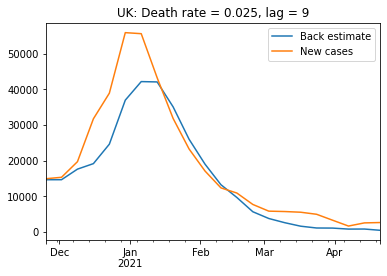

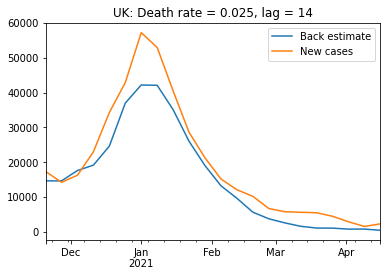

In [ ]:
backestimate(UKcovid,deathpercase=0.029,delay=9).iloc[-150:].resample("7D").mean().plot(title="UK: Death rate = 0.025, lag = 9")
backestimate(UKcovid,deathpercase=0.029,delay=14).iloc[-150:].resample("7D").mean().plot(title="UK: Death rate = 0.025, lag = 14")

                                   Province/State  ...   5/3/21
254                                      Anguilla  ...       95
255                                       Bermuda  ...     2393
256                        British Virgin Islands  ...      216
257                                Cayman Islands  ...      543
258                               Channel Islands  ...     4055
259                   Falkland Islands (Malvinas)  ...       63
260                                     Gibraltar  ...     4283
261                                   Isle of Man  ...     1590
262                                    Montserrat  ...       20
263  Saint Helena, Ascension and Tristan da Cunha  ...        4
264                      Turks and Caicos Islands  ...     2393
265                                           NaN  ...  4421850

[12 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


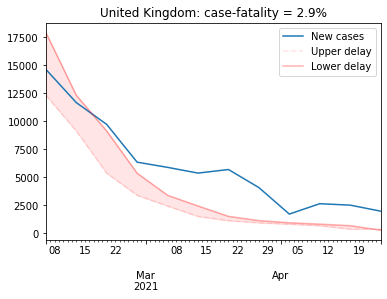

In [ ]:
country_name = "United Kingdom"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=265
deathpc=0.029
date = 80
up = 14
low = 7
onset = 15

# ukcovid = country_covid_by_id(countryID)
backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

In [ ]:
confirm[confirm["Country/Region"]=="US"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
250,NaN,US,40.0,-100.0,1,1,2,2,5,5,5,6,6,8,8,8,11,11,11,12,12,12,12,12,13,13,14,14,14,14,14,14,14,14,16,16,16,16,16,16,...,30013910,30081375,30158696,30221396,30264493,30333922,30395171,30462210,30541255,30611086,30674153,30709125,30786804,30847348,30922386,31002264,31084962,31151497,31197877,31268107,31345985,31421360,31495649,31575640,31628013,31670031,31737964,31799237,31862094,31929351,31991750,32045113,32077178,32124869,32175725,32230850,32289049,32346971,32392274,32421641


In [ ]:
death[death["Country/Region"]=="US"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
250,NaN,US,40.0,-100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,545965,547375,548526,549313,549835,550544,551428,552519,553594,554546,555280,555570,556084,556942,559530,560546,561430,562143,562439,562912,563741,564705,565603,566470,567155,567479,567963,568790,569637,570585,571350,572075,572359,572835,573477,574436,575290,576328,576722,577045


In [ ]:
### US test
USconfirm = confirm[confirm.index==250]
USdeath = death[death.index==250]
USconfirm.rename(index={250: 'confirm'},inplace=True)
USconfirm.drop(USconfirm.columns[0:4], axis=1, inplace=True)
#print(USconfirm)
USdeath.rename(index={250: 'death'},inplace=True)
USdeath.drop(USdeath.columns[0:4], axis=1, inplace=True)
tmp = pd.concat([USconfirm,USdeath])
tmp.rename(columns=pd.to_datetime, inplace=True)
UScovid = tmp.transpose()
UScovid['daily cases'] = UScovid['confirm'].diff().fillna(UScovid.confirm)
UScovid['daily deaths'] = UScovid['death'].diff().fillna(UScovid.death)
#UScovid

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


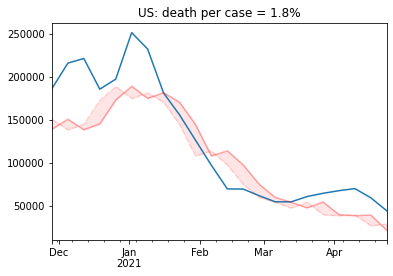

In [ ]:
date = 150
up = 14
low = 7
onset = 15
backestUS = bandbackestimate(UScovid,deathpercase=0.018,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
ax = backestUS["New cases"].plot(title="US: death per case = 1.8%")
backestUS["Upper delay"].plot(style='r--',alpha=0.1)
backestUS["Lower delay"].plot(style='r-',alpha=0.3)
ax.fill_between(backestUS.index,backestUS["Upper delay"],backestUS["Lower delay"],color='red',alpha=0.1)
plt.savefig("US.png",dpi=300)

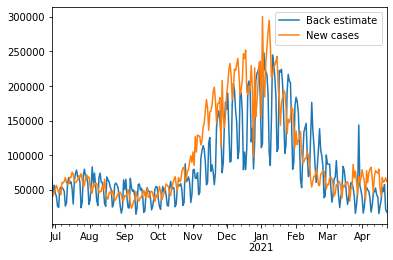

In [ ]:
backestimate(UScovid,deathpercase=0.018,delay=9).iloc[-300:].plot()

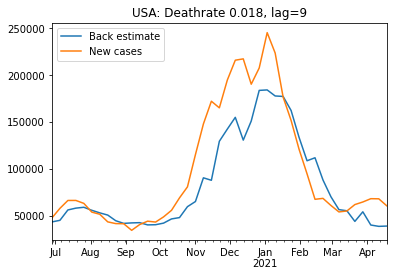

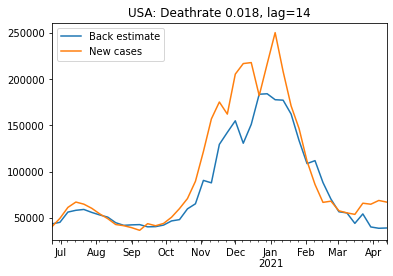

In [ ]:
backestimate(UScovid,deathpercase=0.018,delay=9).iloc[-300:].resample("7D").mean().plot(title="USA: Deathrate 0.018, lag=9")
backestimate(UScovid,deathpercase=0.018,delay=14).iloc[-300:].resample("7D").mean().plot(title="USA: Deathrate 0.018, lag=14")

    Province/State Country/Region   Lat  ...    5/1/21    5/2/21    5/3/21
250            NaN             US  40.0  ...  32392274  32421641  32471562

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


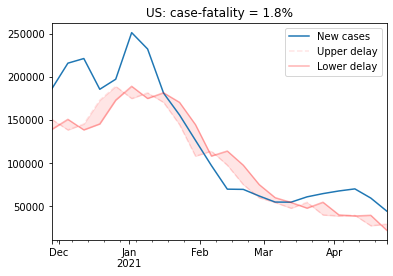

In [ ]:
country_name = "US"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=250
deathpc=0.018
date = 150
up = 14
low = 7
onset = 15

#UScovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

In [ ]:
confirm[confirm["Country/Region"]=="India"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
147,NaN,India,20.593684,78.96288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,160692,160949,161240,161552,161843,162114,162468,162927,163396,164110,164623,165101,165547,166177,166862,167642,168436,169275,170179,171058,172085,173123,174308,175649,177150,178769,180530,182553,184657,186920,189544,192311,195123,197894,201187,204832,208330,211853,215542,218959


In [ ]:
death[death["Country/Region"]=="India"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
147,NaN,India,20.593684,78.96288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,160692,160949,161240,161552,161843,162114,162468,162927,163396,164110,164623,165101,165547,166177,166862,167642,168436,169275,170179,171058,172085,173123,174308,175649,177150,178769,180530,182553,184657,186920,189544,192311,195123,197894,201187,204832,208330,211853,215542,218959


In [ ]:
### India test
Indiaconfirm = confirm[confirm.index==147]
Indiadeath = death[death.index==147]
Indiaconfirm.rename(index={147: 'confirm'},inplace=True)
Indiaconfirm.drop(Indiaconfirm.columns[0:4], axis=1, inplace=True)
#print(Indiaconfirm)
Indiadeath.rename(index={147: 'death'},inplace=True)
Indiadeath.drop(Indiadeath.columns[0:4], axis=1, inplace=True)
tmp = pd.concat([Indiaconfirm,Indiadeath])
tmp.rename(columns=pd.to_datetime, inplace=True)
Indiacovid = tmp.transpose()
Indiacovid['New cases'] = Indiacovid['confirm'].diff().fillna(Indiacovid.confirm)
Indiacovid['daily deaths'] = Indiacovid['death'].diff().fillna(Indiacovid.death)
Indiacovid

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,confirm,death,New cases,daily deaths
2020-01-22,0,0,0.0,0.0
2020-01-23,0,0,0.0,0.0
2020-01-24,0,0,0.0,0.0
2020-01-25,0,0,0.0,0.0
2020-01-26,0,0,0.0,0.0
...,...,...,...,...
2021-04-29,18762976,208330,386555.0,3498.0
2021-04-30,19164969,211853,401993.0,3523.0
2021-05-01,19557457,215542,392488.0,3689.0
2021-05-02,19925517,218959,368060.0,3417.0


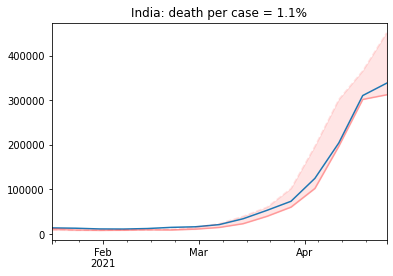

In [ ]:
date = 100
up = 14
low = 7
onset = 15
backestIndia = bandbackestimate(Indiacovid,deathpercase=0.011,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
ax = backestIndia["New cases"].plot(title="India: death per case = 1.1%")
backestIndia["Upper delay"].plot(style='r--',alpha=0.1)
backestIndia["Lower delay"].plot(style='r-',alpha=0.3)
ax.fill_between(backestIndia.index,backestIndia["Upper delay"],backestIndia["Lower delay"],color='red',alpha=0.1)
plt.savefig("India.png",dpi=300)

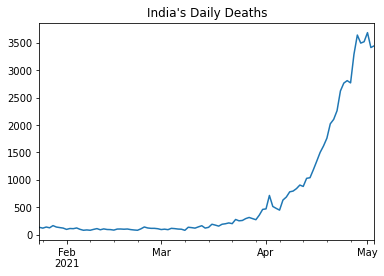

In [ ]:
### Demonstration on how to calculate

#Indiacovid["daily cases"].iloc[-100:].plot()
ax = Indiacovid["daily deaths"].iloc[-100:].plot(title="India's Daily Deaths")
#ax.yaxis("")
plt.savefig("India_death_demon.png",dpi = 300)

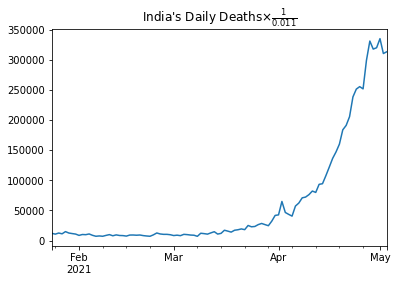

In [ ]:
Indiacovid["scaled up"] = pd.Series(Indiacovid["daily deaths"]/0.011)
Indiacovid["scaled up"].iloc[-100:].plot(title=r"India's Daily Deaths$\times \frac{1}{0.011}$")
plt.savefig("India_deathscaled_demon.png",dpi=300)

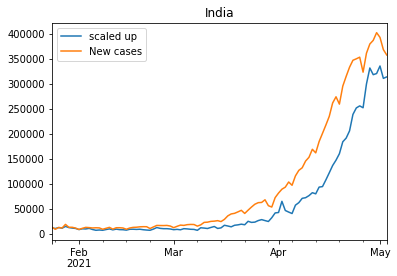

In [ ]:
Indiacovid[["scaled up","New cases"]].iloc[-100:].plot(title=r"India")
plt.savefig("India_deathscaled_vs_daily_cases_demon.png",dpi=300)

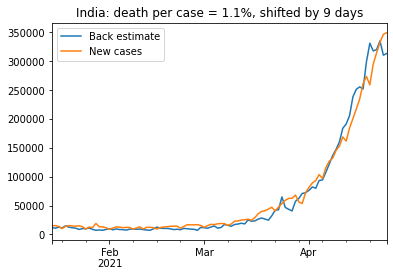

In [ ]:
backestimate(Indiacovid,deathpercase=0.011,delay=9).iloc[-100:].plot(title="India: death per case = 1.1%, shifted by 9 days")
plt.savefig("India_deathscaled_compared_demon.png",dpi=300)

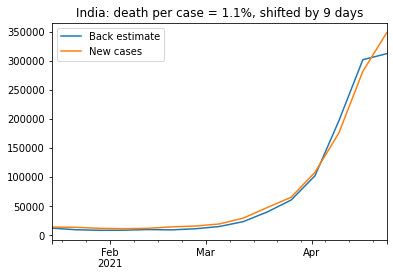

In [ ]:
backestimate(Indiacovid,deathpercase=0.011,delay=9).iloc[-100:].resample("7D").mean().plot(title="India: death per case = 1.1%, shifted by 9 days")
plt.savefig("India_deathscaled_compared_smooth_demon.png",dpi = 300)

    Province/State Country/Region        Lat  ...    5/1/21    5/2/21    5/3/21
147            NaN          India  20.593684  ...  19557457  19925517  20282833

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


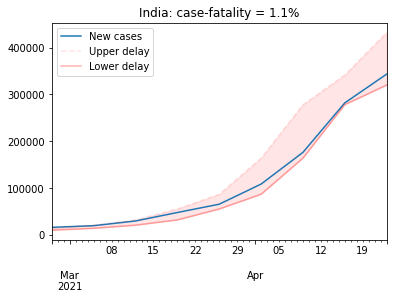

In [ ]:
country_name = "India"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=147
deathpc=0.011
date = 60
up = 14
low = 7
onset = 15

#Indiacovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

In [ ]:
confirm[confirm["Country/Region"]=="Brazil"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
30,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,12220011,12320169,12404414,12490362,12534688,12573615,12658109,12748747,12839844,12910082,12953597,12984956,13013601,13100580,13193205,13279857,13373174,13445006,13482023,13517808,13599994,13673507,13746681,13832455,13900091,13943071,13973695,14043076,14122795,14167973,14237078,14308215,14340787,14369423,14441563,14521289,14590678,14659011,14725975,14754910


In [ ]:
death[death["Country/Region"]=="Brazil"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
30,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,300685,303462,307112,310550,312206,313866,317646,321515,325284,328206,330193,331433,332752,336947,340776,345025,348718,351334,353137,354617,358425,361884,365444,368749,371678,373335,374682,378003,381475,383502,386416,389492,390797,391936,395022,398185,401186,403781,406437,407639


In [ ]:
### Brazil test
Brazilconfirm = confirm[confirm.index==30]
Brazildeath = death[death.index==30]
Brazilconfirm.rename(index={30: 'confirm'},inplace=True)
Brazilconfirm.drop(Brazilconfirm.columns[0:4], axis=1, inplace=True)
Brazildeath.rename(index={30: 'death'},inplace=True)
Brazildeath.drop(Brazildeath.columns[0:4], axis=1, inplace=True)
tmp = pd.concat([Brazilconfirm,Brazildeath])
tmp.rename(columns=pd.to_datetime, inplace=True)
Brazilcovid = tmp.transpose()
Brazilcovid['daily cases'] = Brazilcovid['confirm'].diff().fillna(Brazilcovid.confirm)
Brazilcovid['daily deaths'] = Brazilcovid['death'].diff().fillna(Brazilcovid.death)
Brazilcovid

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,confirm,death,daily cases,daily deaths
2020-01-22,0,0,0.0,0.0
2020-01-23,0,0,0.0,0.0
2020-01-24,0,0,0.0,0.0
2020-01-25,0,0,0.0,0.0
2020-01-26,0,0,0.0,0.0
...,...,...,...,...
2021-04-29,14590678,401186,69389.0,3001.0
2021-04-30,14659011,403781,68333.0,2595.0
2021-05-01,14725975,406437,66964.0,2656.0
2021-05-02,14754910,407639,28935.0,1202.0


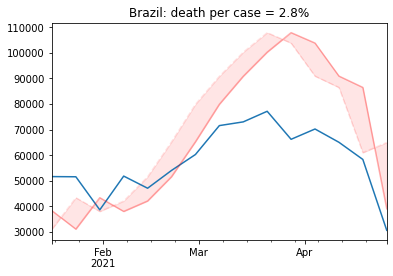

In [ ]:
date = 100
up = 14
low = 7
onset = 15
backestBrazil = bandbackestimate(Brazilcovid,deathpercase=0.028,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
ax = backestBrazil["New cases"].plot(title="Brazil: death per case = 2.8%")
backestBrazil["Upper delay"].plot(style='r--',alpha=0.1)
backestBrazil["Lower delay"].plot(style='r-',alpha=0.3)
ax.fill_between(backestBrazil.index,backestBrazil["Upper delay"],backestBrazil["Lower delay"],color='red',alpha=0.1)
plt.savefig("Brazil.png",dpi=300)

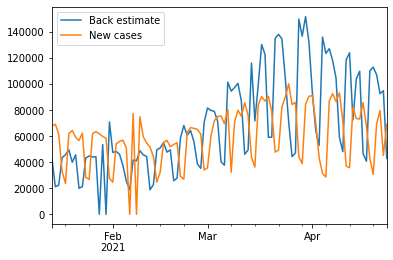

In [ ]:
backestimate(Brazilcovid,deathpercase=0.028,delay=9).iloc[-100:].plot()

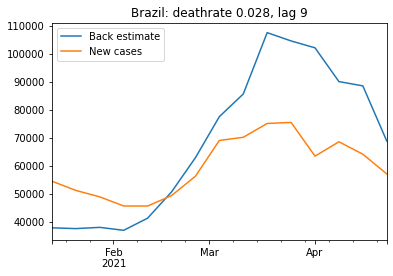

In [ ]:
backestimate(Brazilcovid,deathpercase=0.028,delay=9).iloc[-100:].resample("7D").mean().plot(title="Brazil: deathrate 0.028, lag 9")

   Province/State Country/Region     Lat  ...    5/1/21    5/2/21    5/3/21
30            NaN         Brazil -14.235  ...  14725975  14754910  14779529

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


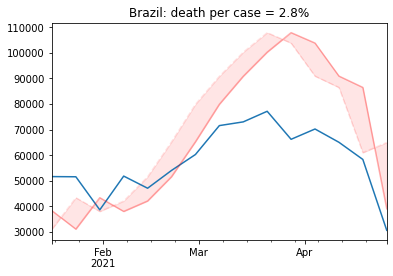

In [ ]:
country_name = "Brazil"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=30
deathpc=0.028
date = 100
up = 14
low = 7
onset = 15

#Brazilcovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)


In [ ]:
death[150:160]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21
150,NaN,Iraq,33.223191,43.679291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14095,14128,14157,14177,14212,14249,14286,14323,14360,14390,14430,14463,14502,14535,14572,14606,14641,14678,14713,14757,14796,14836,14885,14915,14948,14981,15026,15060,15098,15128,15174,15217,15257,15303,15348,15392,15433,15465,15498,15536
151,NaN,Ireland,53.142400,-7.692100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4628,4631,4651,4653,4666,4667,4681,4687,4705,4713,4715,4718,4718,4727,4732,4737,4769,4783,4785,4785,4803,4812,4820,4831,4835,4836,4836,4847,4856,4866,4867,4872,4873,4874,4884,4896,4899,4903,4906,4906
152,NaN,Israel,31.046051,34.851612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6154,6163,6165,6165,6185,6197,6193,6209,6220,6220,6236,6243,6248,6257,6266,6279,6280,6292,6296,6304,6309,6312,6315,6316,6331,6335,6341,6345,6346,6346,6346,6350,6352,6353,6359,6361,6362,6363,6363,6366
153,NaN,Italy,41.871940,12.567380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,7,10,12,...,106339,106799,107256,107636,107933,108350,108879,109346,109847,110328,110704,111030,111326,111747,112374,112861,113579,113923,114254,114612,115088,115557,115937,116366,116676,116927,117243,117633,117997,118357,118699,119021,119238,119539,119912,120256,120544,120807,121033,121177
154,NaN,Jamaica,18.109600,-77.297500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,545,546,557,566,570,586,587,596,599,607,613,615,618,622,631,646,661,669,672,676,682,692,697,713,721,723,727,738,744,751,752,756,760,761,767,770,770,778,779,784
155,NaN,Japan,36.204824,138.252924,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,2,3,3,...,8929,8956,8989,9021,9050,9079,9112,9155,9173,9191,9198,9210,9229,9251,9286,9311,9325,9352,9369,9393,9422,9471,9506,9552,9593,9610,9629,9682,9737,9778,9834,9890,9939,9968,10031,10052,10160,10199,10281,10342
156,NaN,Jordan,31.240000,36.510000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6181,6277,6374,6472,6554,6651,6747,6858,6940,7039,7130,7201,7283,7383,7469,7565,7646,7708,7773,7855,7937,7987,8057,8117,8178,8246,8308,8372,8429,8474,8514,8563,8615,8660,8707,8754,8801,8836,8871,8897
157,NaN,Kazakhstan,48.019600,66.923700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3209,3212,3217,3220,3222,3224,3228,3232,3234,3236,3240,3242,3249,3249,3258,3261,3262,3267,3267,3271,3276,3281,3282,3282,3288,3291,3294,3297,3301,3304,3304,3311,3315,3322,3326,3331,3334,3334,3341,3349
158,NaN,Kenya,-0.023600,37.906200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2066,2092,2098,2104,2117,2135,2147,2153,2167,2186,2206,2224,2244,2258,2276,2292,2309,2330,2348,2368,2394,2420,2424,2443,2463,2481,2501,2519,2540,2560,2583,2603,2622,2643,2665,2688,2707,2724,2744,2763
159,NaN,"Korea, South",35.907757,127.766922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,6,8,10,12,...,1709,1716,1721,1722,1726,1729,1731,1735,1737,1740,1744,1748,1752,1756,1758,1764,1765,1768,1770,1775,1782,1788,1790,1794,1797,1801,1802,1806,1808,1811,1812,1813,1817,1820,1821,1825,1828,1831,1833,1834


In [ ]:
### Korea test
Koreaconfirm = confirm[confirm.index==159]
Koreadeath = death[death.index==159]
Koreaconfirm.rename(index={159: 'confirm'},inplace=True)
Koreaconfirm.drop(Koreaconfirm.columns[0:4], axis=1, inplace=True)
#print(Indiaconfirm)
Koreadeath.rename(index={159: 'death'},inplace=True)
Koreadeath.drop(Koreadeath.columns[0:4], axis=1, inplace=True)
tmp = pd.concat([Koreaconfirm,Koreadeath])
tmp.rename(columns=pd.to_datetime, inplace=True)
Koreacovid = tmp.transpose()
Koreacovid['daily cases'] = Koreacovid['confirm'].diff().fillna(Koreacovid.confirm)
Koreacovid['daily deaths'] = Koreacovid['death'].diff().fillna(Koreacovid.death)
Koreacovid

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,confirm,death,daily cases,daily deaths
2020-01-22,1,0,1.0,0.0
2020-01-23,1,0,0.0,0.0
2020-01-24,2,0,1.0,0.0
2020-01-25,2,0,0.0,0.0
2020-01-26,3,0,1.0,0.0
...,...,...,...,...
2021-04-29,122007,1828,656.0,3.0
2021-04-30,122634,1831,627.0,3.0
2021-05-01,123240,1833,606.0,2.0
2021-05-02,123728,1834,488.0,1.0


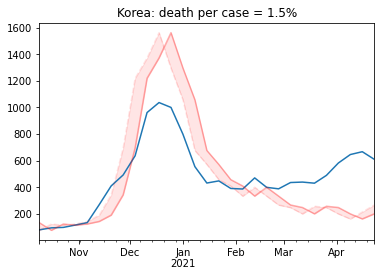

In [ ]:
date = 200
up = 14
low = 7
onset = 15
backestKorea = bandbackestimate(Koreacovid,deathpercase=0.015,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
ax = backestKorea["New cases"].plot(title="Korea: death per case = 1.5%")
backestKorea["Upper delay"].plot(style='r--',alpha=0.1)
backestKorea["Lower delay"].plot(style='r-',alpha=0.3)
ax.fill_between(backestKorea.index,backestKorea["Upper delay"],backestKorea["Lower delay"],color='red',alpha=0.1)
plt.savefig("Korea.png",dpi=300)

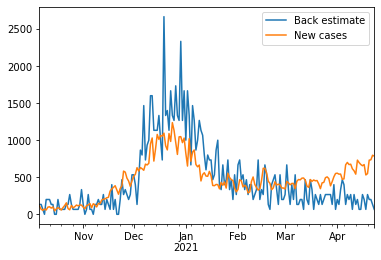

In [ ]:
backestimate(Koreacovid,deathpercase=0.015,delay=9).iloc[-200:].plot()

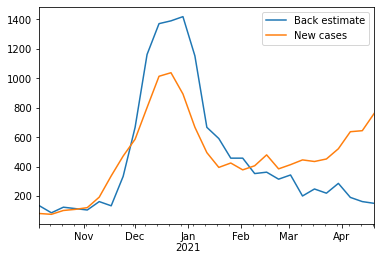

In [ ]:
backestimate(Koreacovid,deathpercase=0.015,delay=9).iloc[-200:].resample("7D").mean().plot()

In [ ]:
UKcovid['pct_cases'] = UKcovid['daily cases'].pct_change().fillna(0)
UKcovid['pct_deaths'] = UKcovid['daily deaths'].pct_change().fillna(0)

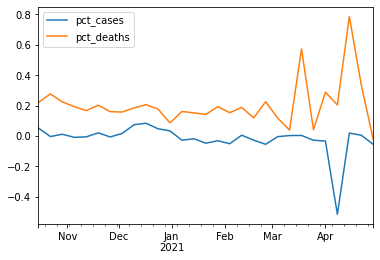

In [ ]:
UKcovid.iloc[-200:,-2:].resample("7D").mean().plot()

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20, 3/30/20, 3/31/20, 4/1/20, 4/2/20, 4/3/20, 4/4/20, 4/5/20, 4/6/20, 4/7/20, 4/8/20, 4/9/20, 4/10/20, 4/11/20, 4/12/20, 4/13/20, 4/14/20, 4/15/20, 4/16/20, 4/17/20, 4/18/20, 4/19/20, 4/20/20, 4/21/20, 4/22/20, 4/23/20, 4/24/20, 4/25/20, 4/26/20, ...]
Index: []

[0 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


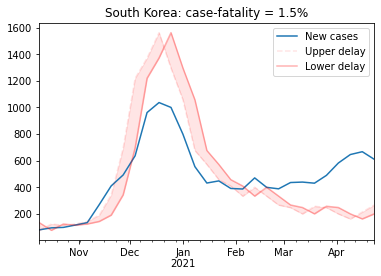

In [ ]:
country_name = "South Korea"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=159
deathpc=0.015
date = 200
up = 14
low = 7
onset = 15

#Koreacovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region      Lat  ...   5/1/21   5/2/21   5/3/21
182            NaN         Mexico  23.6345  ...  2347780  2348873  2349900

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


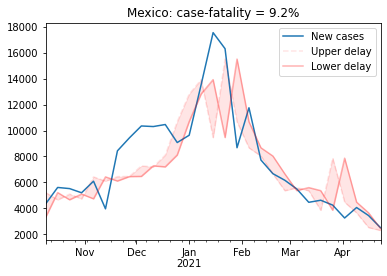

In [ ]:
country_name = "Mexico"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=182
deathpc=0.092
date = 200
up = 14
low = 7
onset = 15

#Mexicocovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region        Lat  ...   5/1/21   5/2/21   5/3/21
234            NaN          Spain  40.463667  ...  3524077  3524077  3540430

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


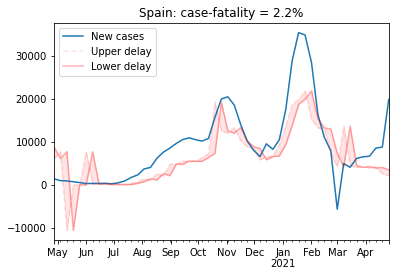

In [ ]:
country_name = "Spain"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=234
deathpc=0.022
date = 365
up = 14
low = 7
onset = 15

#Spaincovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

                Province/State Country/Region  ...   5/2/21   5/3/21
119              French Guiana         France  ...    19543    19543
120           French Polynesia         France  ...    18758    18765
121                 Guadeloupe         France  ...    14634    14634
122                 Martinique         France  ...    11139    11139
123                    Mayotte         France  ...    20094    20094
124              New Caledonia         France  ...      124      124
125                    Reunion         France  ...    20381    20381
126           Saint Barthelemy         France  ...      974      974
127  Saint Pierre and Miquelon         France  ...       25       25
128                  St Martin         France  ...     1745     1745
129          Wallis and Futuna         France  ...      444      444
130                        NaN         France  ...  5605532  5609292

[12 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


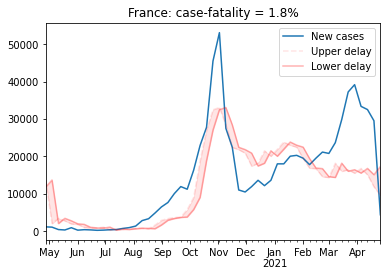

In [ ]:
country_name = "France"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=130
deathpc=0.018
date = 365
up = 14
low = 7
onset = 15

#Francecovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region       Lat  ...   5/1/21   5/2/21   5/3/21
153            NaN          Italy  41.87194  ...  4035617  4044762  4050708

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


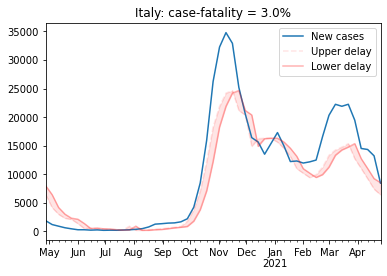

In [ ]:
country_name = "Italy"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=153
deathpc=0.030
date = 365
up = 14
low = 7
onset = 15

#Italycovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region        Lat  ...   5/1/21   5/2/21   5/3/21
134            NaN        Germany  51.165691  ...  3423900  3432676  3438186

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


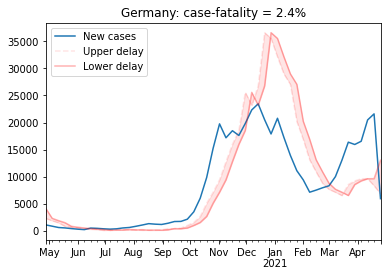

In [ ]:
country_name = "Germany"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=134
deathpc=0.024
date = 365
up = 14
low = 7
onset = 15

#Germanycovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20, 3/30/20, 3/31/20, 4/1/20, 4/2/20, 4/3/20, 4/4/20, 4/5/20, 4/6/20, 4/7/20, 4/8/20, 4/9/20, 4/10/20, 4/11/20, 4/12/20, 4/13/20, 4/14/20, 4/15/20, 4/16/20, 4/17/20, 4/18/20, 4/19/20, 4/20/20, 4/21/20, 4/22/20, 4/23/20, 4/24/20, 4/25/20, 4/26/20, ...]
Index: []

[0 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


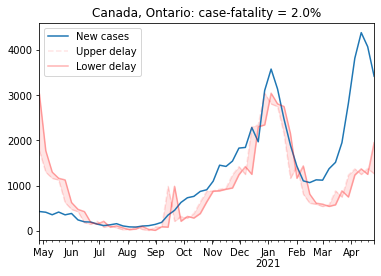

In [ ]:
country_name = "Canada, Ontario"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=49
deathpc=0.020
date = 365
up = 14
low = 7
onset = 15

#Ontariocovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20, 3/30/20, 3/31/20, 4/1/20, 4/2/20, 4/3/20, 4/4/20, 4/5/20, 4/6/20, 4/7/20, 4/8/20, 4/9/20, 4/10/20, 4/11/20, 4/12/20, 4/13/20, 4/14/20, 4/15/20, 4/16/20, 4/17/20, 4/18/20, 4/19/20, 4/20/20, 4/21/20, 4/22/20, 4/23/20, 4/24/20, 4/25/20, 4/26/20, ...]
Index: []

[0 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


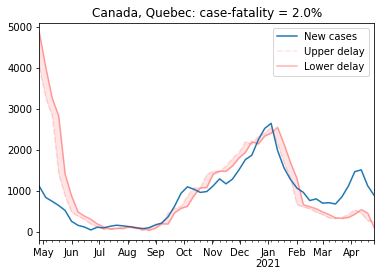

In [ ]:
country_name = "Canada, Quebec"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=51
deathpc=0.020
date = 365
up = 14
low = 7
onset = 15

#Ontariocovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region        Lat  ...  5/1/21  5/2/21  5/3/21
238            NaN         Sweden  60.128161  ...  973604  973604  973604

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


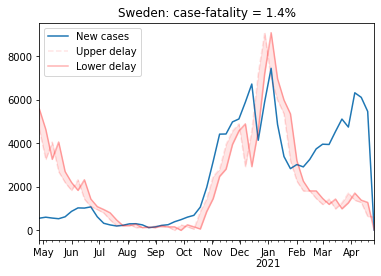

In [ ]:
country_name = "Sweden"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=238
deathpc=0.014
date = 365
up = 14
low = 7
onset = 15

#Swedencovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region     Lat  ...  5/1/21  5/2/21  5/3/21
227            NaN      Singapore  1.2833  ...   61179   61218   61235

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


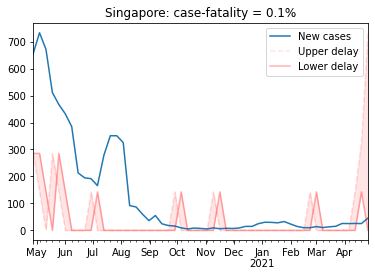

In [ ]:
country_name = "Singapore"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=227
deathpc=0.001
date = 365
up = 14
low = 7
onset = 15

#Italycovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)

    Province/State Country/Region        Lat  ...  5/1/21  5/2/21  5/3/21
244            NaN       Thailand  15.870032  ...   67044   68984   71025

[1 rows x 472 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


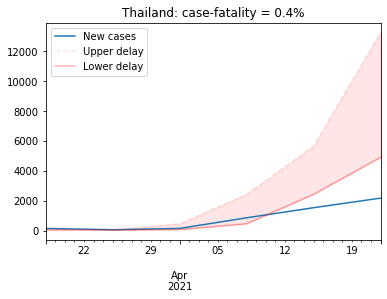

In [ ]:
country_name = "Thailand"
# This prints out the country name to make sure you get the country ID right
print(confirm[confirm["Country/Region"]==country_name])
countryID=244
deathpc=0.004
date = 40
up = 14
low = 7
onset = 15

#Germanycovid = country_covid_by_id(countryID)

backest = bandbackestimate(country_covid_by_id(countryID),deathpercase=deathpc,delayupper=up,delaylower=low,onsetexpo = onset).iloc[-date:].resample("7D").mean()
drawbandplot(backest,country_name,death_per_case=deathpc)